In [1]:
!pip install biopython

In [2]:
import os
import requests

from Bio.PDB import PDBParser
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F


In [3]:
def download_pdb(pdb_id, out_dir="pdb_files"):
    """Download a PDB file from RCSB and save it locally."""
    pdb_id = pdb_id.lower()
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{pdb_id}.pdb")

    response = requests.get(url)
    if response.status_code == 200:
        with open(out_path, "w") as f:
            f.write(response.text)
    else:
        print(f"Failed to download {pdb_id}: status code {response.status_code}")


def extract_ca_fragments(pdb_file, fragment_length=20):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    fragments = []

    for model in structure:
        for chain in model:
            ca_coords = []

            for residue in chain:
                if 'CA' in residue:
                    ca = residue['CA'].get_vector().get_array()
                    ca_coords.append(ca)

            ca_coords = np.array(ca_coords)
            # slide window over full C-alpha chain
            for i in range(len(ca_coords) - fragment_length + 1):
                fragment = ca_coords[i : i + fragment_length]
                fragments.append(fragment)

    if len(fragments) == 0:
        return None
    return np.array(fragments)  # np arrays of shape (N, fragment_length, 3)

# List of example PDB IDs (real proteins)
pdb_ids = ["1CRN", "1A8O", "4HHB", "2PTC", "3NIR", "5MBN", "6LU7", "1BNA", "1HHP", "2HYY"]
data = []
peptide_length = 20

# Download and read from all the pdb files
for pdb_id in pdb_ids:
    download_pdb(pdb_id)
    pdb_file = f"pdb_files/{pdb_id.lower()}.pdb"
    fragments = extract_ca_fragments("/content/" + pdb_file, fragment_length=peptide_length)
    if fragments is not None:
      data.append(fragments)


data = np.concatenate(data, axis=0)
print(data.shape)


(2326, 20, 3)


In [4]:
data_center = np.mean(data, axis=1)
data_center = data_center[:, np.newaxis, :]
data = data - data_center

In [5]:
data[10]

array([[ 1.84369998, -7.34609992,  5.63250009],
       [-1.11129995, -4.99509997,  4.81849996],
       [ 1.27269988, -2.57210011,  3.12249987],
       [ 2.67469983, -5.3230998 ,  0.85849993],
       [-0.87429996, -6.33109993, -0.19049998],
       [-1.76629992, -2.64510006, -0.80649992],
       [ 1.23869996, -2.44110007, -3.14550002],
       [ 0.27670006, -5.49909992, -5.25849994],
       [-1.86429997, -3.55409998, -7.72949989],
       [ 0.70970015, -0.73909993, -7.95050009],
       [-0.88930006,  1.6789003 , -5.44549997],
       [ 1.4867001 ,  4.58289962, -4.62850006],
       [ 3.4577003 ,  4.17289978, -1.43249996],
       [ 1.95769982,  7.38689952, -0.01949998],
       [-1.58230014,  5.96390014, -0.17649992],
       [-0.47630019,  2.61889988,  1.25450007],
       [ 1.22270016,  4.57189994,  4.09350006],
       [-1.96530004,  6.29089981,  5.2614998 ],
       [-3.94130005,  3.11490017,  4.7245001 ],
       [-1.67029996,  1.06390052,  7.01749985]])

In [6]:
def sample_real_protein_fragment(n_samples=50):
  batch_indices = np.random.randint(0, len(data), n_samples) #with replacement
  return data[batch_indices]

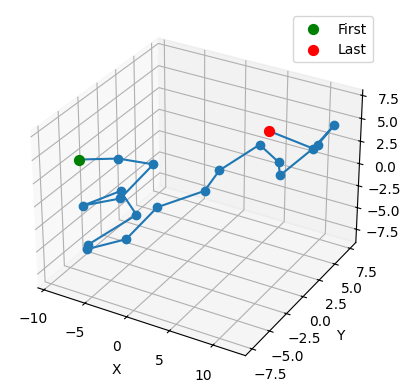

In [7]:
x, y, z = data[20][:, 0], data[10][:, 1], data[10][:, 2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, marker='o')  # connected line with markers
# Alternatively: ax.scatter(x, y, z)  # just points

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.scatter(x[0], y[0], z[0], color='green', s=50, label="First")
ax.scatter(x[-1], y[-1], z[-1], color='red', s=50, label="Last")
ax.legend()

plt.show()

In [8]:
def generate_gaussian_samples(num_samples = 5, length=10, dim=3):
    samples = np.random.randn(num_samples, length, dim)
    return samples

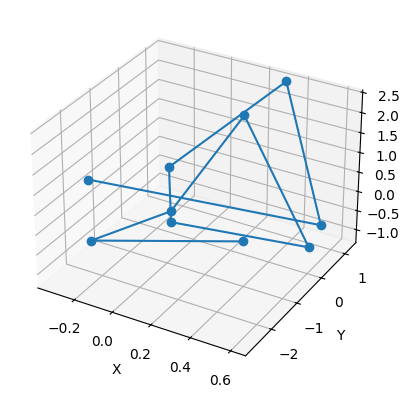

In [9]:
gaussian_sample = generate_gaussian_samples(num_samples=1)[0]


# Extract x, y, z columns
x, y, z = gaussian_sample[:, 0], gaussian_sample[:, 1], gaussian_sample[:, 2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, marker='o')  # connected line with markers
# Alternatively: ax.scatter(x, y, z)  # just points

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class FlowModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv1d(5, 32, kernel_size=3, padding=1),  # layer 1
            nn.ReLU(),
            nn.Conv1d(32, 3, kernel_size=1)              # layer 2
        )

    def forward(self, x_t, t):
        """
        Args:
            x_t: Tensor of shape (batch_size, L, 3) — interpolated points
            t:   Tensor of shape (batch_size,) — time scalars

        Returns:
            v_t: Tensor of shape (batch_size, L, 3) — predicted velocity vectors
        """
        B, L, _ = x_t.shape
        t = t.view(B, 1, 1).expand(B, L, 1)  # shape: (batch size, peptide len, 1)

        pos = torch.arange(L).float() / (L - 1)  # Normalize to [0, 1]
        pos = pos.view(1, L, 1).expand(B, L, 1)  # shape: (B, L, 1)
        pos = pos.to(device)

        xt_input = torch.cat([x_t, t, pos], dim=-1)  # shape: (batch size, peptide len, 5)
        xt_input = xt_input.permute(0, 2, 1)  # shape: (batch size, 5, peptide len)
        v_t = self.model(xt_input)  # shape: (batch size, 3, peptide len)
        return v_t.permute(0, 2, 1)  # shape: (batch size, peptide len, 3)

# Instantiate model and optimizer
model = FlowModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


dim = 3 #each C-alpha atom will be getting plotted in 3d space

# Training loop
def train(model, steps=500000, batch_size=512):
    model.train()
    for step in range(steps):
        # Sample from coupling
        x_base = torch.tensor(generate_gaussian_samples(num_samples=batch_size, length=peptide_length, dim=dim), dtype=torch.float32).to(device)  # (batch sz, peptide len, 3)
        x_target = torch.tensor(sample_real_protein_fragment(n_samples=batch_size), dtype=torch.float32).to(device) # (batch sz, peptide_len, 3)
        v_true = x_target - x_base  # (batch sz, peptide_len, 3)

        t = torch.rand(batch_size, device=device)  # (batch_size,)

        t = t.view(batch_size, 1, 1)
        x_t = t* x_target + (1-t) * x_base #linear interpolation; t=0 -> x_base; t=1 -> x_target

        # Predict velocity
        #x_t is of shape (batch size, peptide len, 3)
        v_hat = model(x_t, t)

        loss = F.mse_loss(v_hat, v_true)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 10000 == 0:
            print(f"[{step}] Loss: {loss.item():.6f}")

# Run training
train(model)


[0] Loss: 29.052662
[10000] Loss: 6.447651
[20000] Loss: 6.776383
[30000] Loss: 6.573709
[40000] Loss: 6.949155
[50000] Loss: 6.012447
[60000] Loss: 6.454971
[70000] Loss: 6.582851
[80000] Loss: 6.247884
[90000] Loss: 6.600103
[100000] Loss: 6.580552
[110000] Loss: 6.185086
[120000] Loss: 6.652196
[130000] Loss: 7.227165
[140000] Loss: 6.554142
[150000] Loss: 6.905245
[160000] Loss: 6.444889
[170000] Loss: 6.095667
[180000] Loss: 6.095059
[190000] Loss: 6.202514
[200000] Loss: 5.778950
[210000] Loss: 7.094197
[220000] Loss: 5.624868
[230000] Loss: 6.141079
[240000] Loss: 6.089486
[250000] Loss: 6.283757
[260000] Loss: 6.423222
[270000] Loss: 6.084056
[280000] Loss: 6.460769
[290000] Loss: 6.054960
[300000] Loss: 5.894965
[310000] Loss: 6.288167
[320000] Loss: 6.541347
[330000] Loss: 5.789751
[340000] Loss: 6.560032
[350000] Loss: 5.742903
[360000] Loss: 6.640038
[370000] Loss: 5.674482
[380000] Loss: 6.215192
[390000] Loss: 5.793001
[400000] Loss: 6.151611
[410000] Loss: 6.043279
[4200

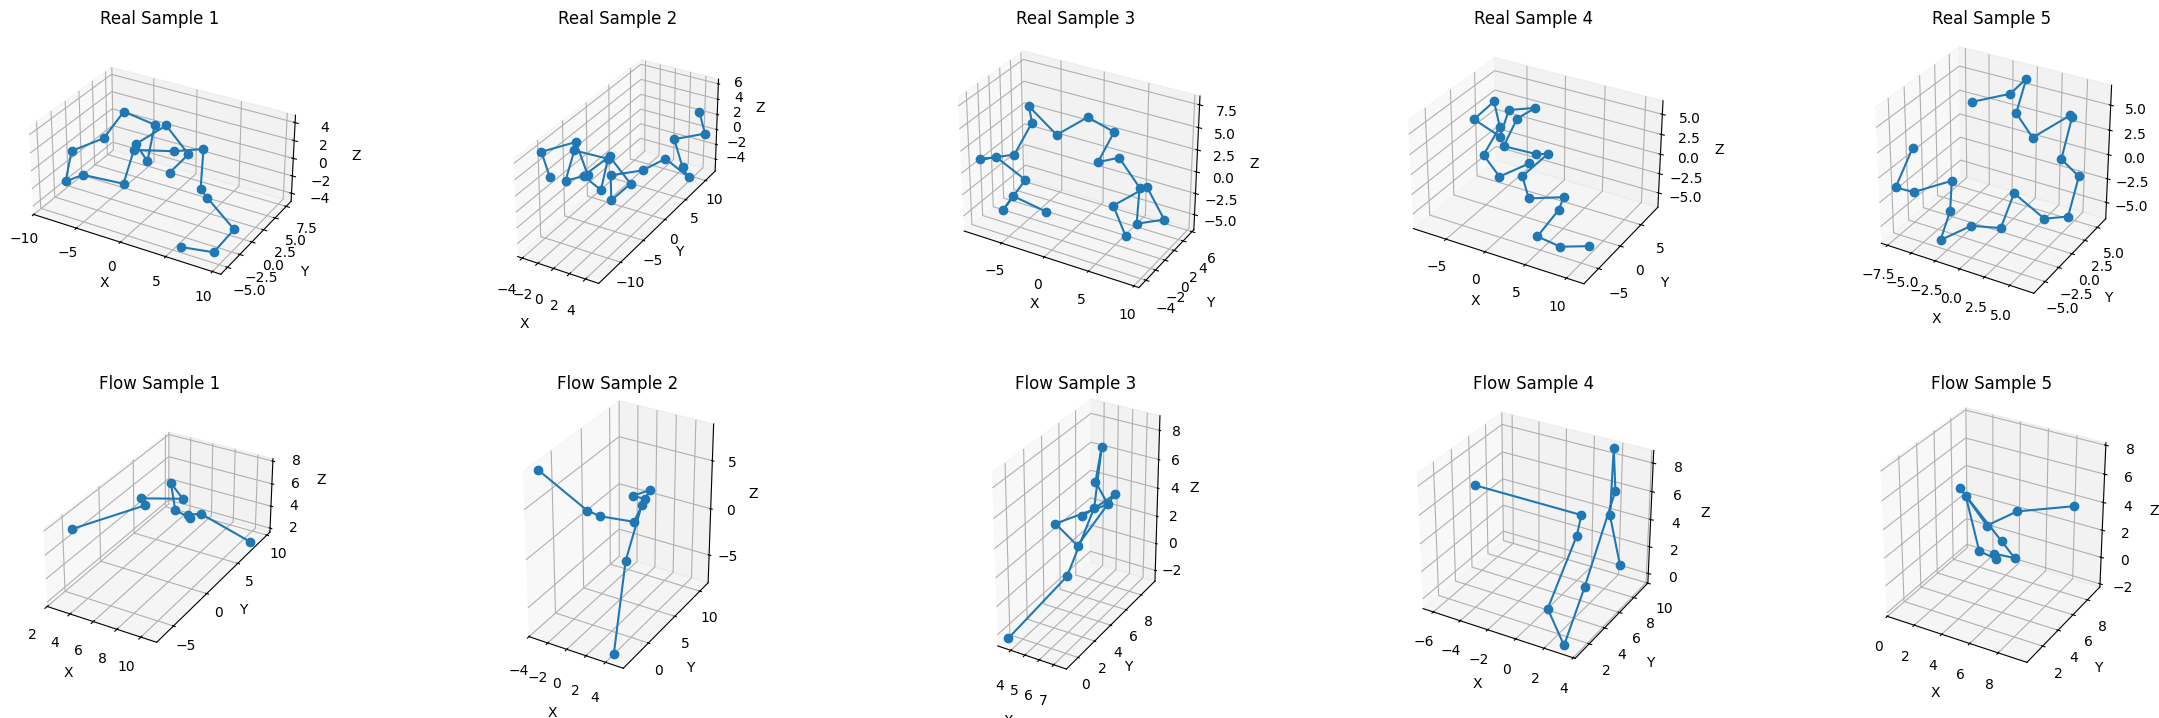

In [12]:
@torch.no_grad()
def sample_from_flow(model, n_samples=5, n_steps=10000):
    model.eval()
    x = torch.tensor(generate_gaussian_samples(num_samples=n_samples), dtype=torch.float32).to(device)  # Start at t=1
    t_vals = torch.linspace(1.0, 0.0, steps=n_steps + 1).to(device)

    for i in range(n_steps):
        t = t_vals[i]
        dt = t_vals[i] - t_vals[i+1]  # positive step size
        v = model(x, t.expand(n_samples))
        x = x + dt * v

    return x.cpu().numpy()

samples = sample_from_flow(model)

sample_from_real_target = sample_real_protein_fragment(n_samples=5)

# Plot the generated helices
fig = plt.figure(figsize=(24, 8))

for i in range(sample_from_real_target.shape[0]):
    ax = fig.add_subplot(2, sample_from_real_target.shape[0], i + 1, projection='3d')
    ax.plot(sample_from_real_target[i, :, 0], sample_from_real_target[i, :, 1], sample_from_real_target[i, :, 2], marker='o')
    ax.set_title(f'Real Sample {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal', adjustable='box')

for i in range(samples.shape[0]):
    ax = fig.add_subplot(2, sample_from_real_target.shape[0], sample_from_real_target.shape[0] + i + 1, projection='3d')
    ax.plot(samples[i, :, 0], samples[i, :, 1], samples[i, :, 2], marker='o')
    ax.set_title(f'Flow Sample {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal', adjustable='box')


fig.tight_layout(pad=5.0) # Increased padding
plt.show()